## Deep Learning Capstone Project
## Facial Emotion Detection
Jeff Stearns

# <span style="color:black">Problem Definition</span>

**Context:**<br>
The analysis of human facial expressions using Artificial Intelligence can potentially provide a better understanding of human behavior. AI emotion detection can also potentially assist security such as airport and police in identifying potential threats in a particular setting. Facial expression conveys valuable non verbal communication cues.

**Objective:**<br>
This project utilizes the power of Convolutional Neural Networks (CNN) to create models capable of classification of images into four categories of facial expressions: Happy, sad, neutral and surprise. The dataset provided for this project, Facial_emotion_images.zip, contains 20,000+ grayscale images split into training, validation and test datasets. All images are 48 pixel squares, a low resolution dataset.

A high level view of the CNN model development for this project is to develop two preliminary grayscale/RGB CNN models, followed by three Transfer Learning CNNs (VGG16, ResNetv2 and EfficientNet) and finally attempt to improve upon the afore mentioned CNNs by experimenting with additional CNN layers, numbers of neurons, pooling layers, flattening, batchnormalization and dropout layers.

**Key Questions:**<br>
* How do our base CNN models compare with Transfer learning models of greater complexity?
* Can we improve on our base CNN models through trial and error?
* Is the dataset good enough in both quantity and quality?
* Average natural human ability to detect emotions is around 90%, can we approach this level?
* Are there any ethical issues with CNN/AI facial emotion detection or is it innocuous because it does not involve identity?
* Is the final model for the Capstone project good enough for deployment?




## **About the Dataset**

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'.
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>

## **Importing the Libraries**

In [ ]:
# Used to unzip the source data
import zipfile

import numpy as np
import pandas as pd
import os
import h5py
import random

import matplotlib.pyplot as plt
import seaborn as sns

# Importing Deep Learning Libraries, layers, models, optimizers, etc
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.applications as ap
from tensorflow.keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend
import tensorflow as tf

# Sci-Kit Learn : Predictive data analysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

**Import the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to Facial Library ZIP File in Google drive
face_file = '/content/drive/MyDrive/MITAppliedDataScience/FacialRecognition/Facial_emotion_images.zip'

# Extracting image files from the zip file
with zipfile.ZipFile(face_file, "r") as zip_ref:
    zip_ref.extractall()

# Setup subdirectory pointers
train_dir = "Facial_emotion_images/train/"
validation_dir = "Facial_emotion_images/validation/"
test_dir = "Facial_emotion_images/test/"
# Size of images in dataset is 48 pixels square
img_size = 48

Mounted at /content/drive


## **Visualizing our Classes**


In [ ]:
# Display first 16 images from the specified training folder
def get_image(emotion):
    train_emotion = train_dir + emotion + "/"
    plt.figure(figsize = (10, 10))

    for i in range(1, 17):
        plt.subplot(4, 4, i)
        img = load_img(train_emotion +
                    os.listdir(train_emotion)[i],
                    target_size = (img_size, img_size))
        plt.imshow(img)

    plt.show()

### **Happy**

First 16 training images labeled as 'Happy':


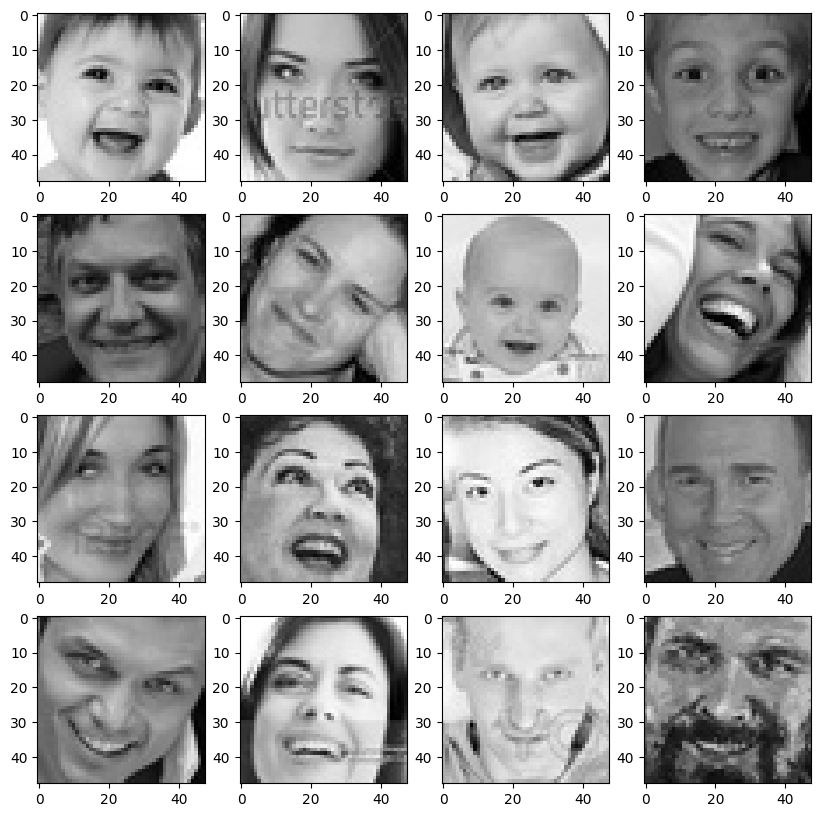

In [ ]:
print("First 16 training images labeled as 'Happy':")
get_image("happy")

**Observations - Happy**<br>
* Generally face is smiling, sometimes with teeth visible.
* Images without a face observed, "fixed" dataset may be generated in final analysis.
* Some images are questionable in terms of illustrating happy, missed predictions will be analyzed.
* Some images contain hats, eyeglasses, hands blocking part of face and watermarks. Models will need to handle these issues.
* Data augmentation is required for rotated and tilted images.

### **Sad**

First 16 training images labeled as 'Sad':


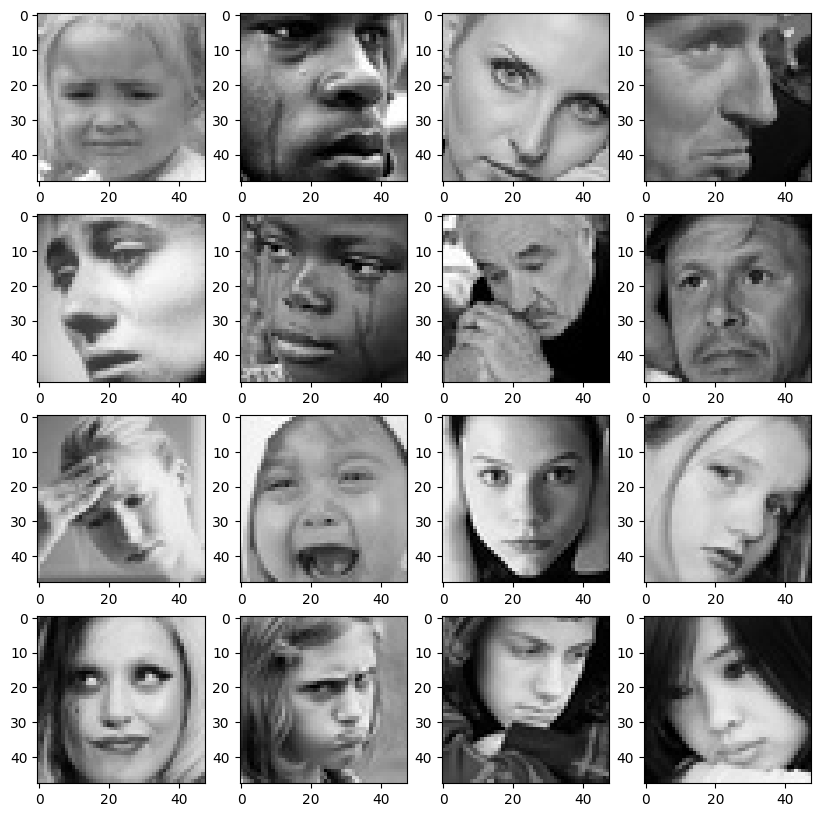

In [ ]:
print("First 16 training images labeled as 'Sad':")
get_image("sad")

**Observations - Sad**<br>
* Generally face is frowning.
* Eyes are often closed.
* As with 'happy' dataset, some images appear to be mischaracterized.
* Despite low resolution of images, clear distinction exists between happy and sad images in general.

### **Neutral**

First 16 training images labeled as 'Neutral':


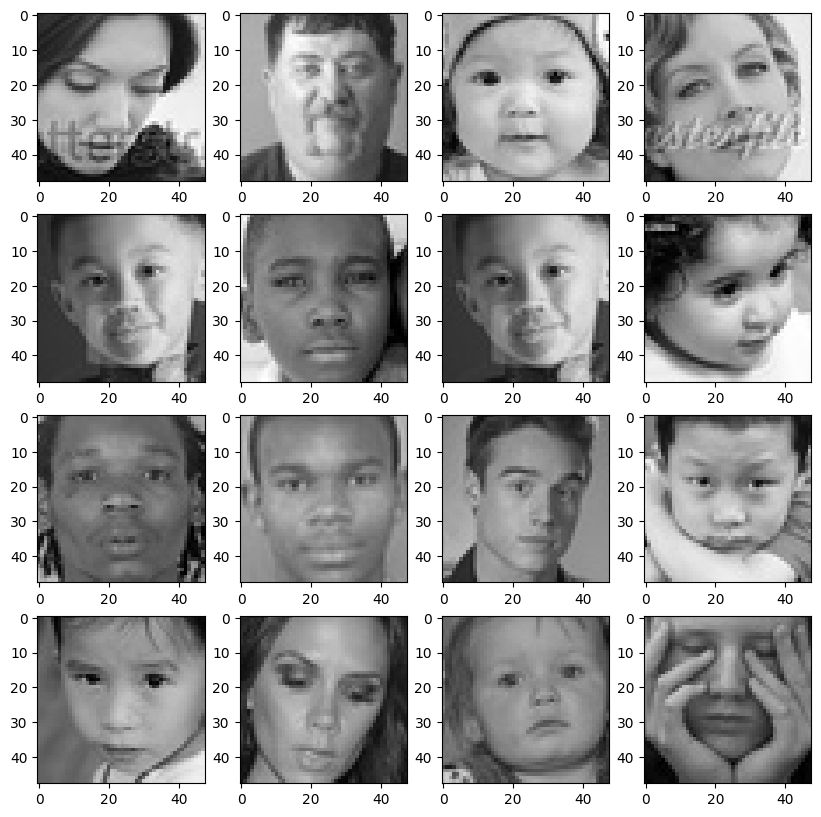

In [ ]:
print("First 16 training images labeled as 'Neutral':")
get_image("neutral")

**Observations - Neutral**<br>
* Neutral images are generally less distinctive in terms of detectable edges or features compared to other classes.
* Lips straight, not tilted up or down is perhaps the most distinctive feature.
* Mischaracterized and images without faces also exist in this dataset.

### **Surprise**

First 16 training images labeled as 'Surprise':


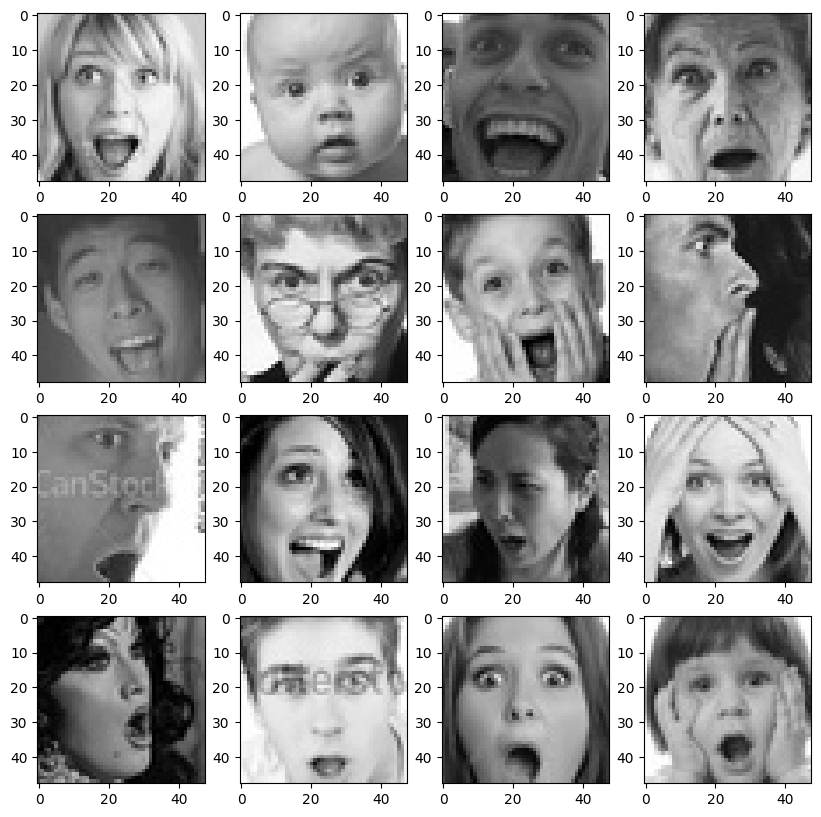

In [ ]:
print("First 16 training images labeled as 'Surprise':")
get_image("surprise")

**Observations - Surprise**<br>
* Readily detectable features include open mouths and wide eyes. Not every image includes these features but it is common.
* As with other categories, some images do not contain faces or are mischaracterized.

**Training Set Images**

In [ ]:
# Print number of images in each folder of the training set
train_happy = len(os.listdir(train_dir + "happy/"))
print("Training Set Happy images: " + str(train_happy))
train_sad = len(os.listdir(train_dir + "sad/"))
print("Training Set Sad images: " + str(train_sad))
train_neutral = len(os.listdir(train_dir + "neutral/"))
print("Training Set Neutral images: " + str(train_neutral))
train_surprise = len(os.listdir(train_dir + "surprise/"))
print("Training Set Surprise images: " + str(train_surprise))

train_total = train_happy + train_sad + train_neutral + train_surprise

print("\nTraining Set Surprise Percentage : %.3f" % (train_surprise/train_total*100))
print("\nTotal Training Images: " + str(train_total))


Training Set Happy images: 3976
Training Set Sad images: 3982
Training Set Neutral images: 3978
Training Set Surprise images: 3173

Training Set Surprise Percentage : 21.001

Total Training Images: 15109


**Observations: Training Images**<br>
* Happy, sad, and neutral images are basically equal with slightly less surprise images (21%).
* There are 15,109 training images in total.



In [ ]:
# Print number of images in each folder of the validation set
val_happy = len(os.listdir(validation_dir + "happy/"))
print("Validation Set Happy images: " + str(val_happy))
val_sad = len(os.listdir(validation_dir + "sad/"))
print("Validation Set Sad images: " + str(val_sad))
val_neutral = len(os.listdir(validation_dir + "neutral/"))
print("Validation Set Neutral images: " + str(val_neutral))
val_surprise = len(os.listdir(validation_dir + "surprise/"))
print("Validation Set Surprise images: " + str(val_surprise))

val_total = val_happy + val_sad + val_neutral + val_surprise

print("\nValidation Set Happy Percentage : %.3f" % (val_happy/val_total*100))
print("Validation Set Sad Percentage : %.3f" % (val_sad/val_total*100))
print("Validation Set Neutral Percentage : %.3f" % (val_neutral/val_total*100))
print("Validation Set Surprise Percentage : %.3f" % (val_surprise/val_total*100))
print("\nTotal Validation Images: " + str(val_total))


Validation Set Happy images: 1825
Validation Set Sad images: 1139
Validation Set Neutral images: 1216
Validation Set Surprise images: 797

Validation Set Happy Percentage : 36.669
Validation Set Sad Percentage : 22.885
Validation Set Neutral Percentage : 24.432
Validation Set Surprise Percentage : 16.014

Total Validation Images: 4977


**Observations: Validation Images**<br>
* Class distribution in validation image sets are more imbalanced than the training set.
* There are 4,977 validation images in total.


In [ ]:
# Print number of images in each folder of the training set
test_happy = len(os.listdir(test_dir + "happy/"))
print("Test Set Happy images: " + str(test_happy))
test_sad = len(os.listdir(test_dir + "sad/"))
print("Test Set Sad images: " + str(test_sad))
test_neutral = len(os.listdir(test_dir + "neutral/"))
print("Test Set Neutral images: " + str(test_neutral))
test_surprise = len(os.listdir(test_dir + "surprise/"))
print("Test Set Surprise images: " + str(test_surprise))

test_total = test_happy + test_sad + test_neutral + test_surprise

print("\nTotal Test Images: " + str(test_total))

# Getting count of images in each test folder and saving to variables

test_happy = len(os.listdir(test_dir + "happy/"))
test_sad = len(os.listdir(test_dir + "sad/"))
test_neutral = len(os.listdir(test_dir + "neutral/"))
test_surprised = len(os.listdir(test_dir + "surprise/"))


Test Set Happy images: 32
Test Set Sad images: 32
Test Set Neutral images: 32
Test Set Surprise images: 32

Total Test Images: 128


**Observations: Test Images**<br>
* Unlike the training and validation data sets, the test data set has even class distribution.
* There are 128 test images in total, very small set compared to training and validation and smaller percentage than typically used for data set splits.


In [ ]:
# Calculate total size of dataset and percentage of images in training, validation and test data sets
image_total = train_total + val_total + test_total

print("\nTraining Set Percentage of Total Dataset : %.3f" % (train_total/image_total*100))
print("\nValidation Set Percentage of Total Dataset : %.3f" % (val_total/image_total*100))
print("\nTest Set Percentage of Total Dataset : %.3f" % (test_total/image_total*100))



Training Set Percentage of Total Dataset : 74.745

Validation Set Percentage of Total Dataset : 24.622

Test Set Percentage of Total Dataset : 0.633


**Observations:**<br>
* Number of test set images is extremely low with our source dataset.
* The training percentage versus validation percentage is a normal segmentation of a dataset.


## **Creating Data Loaders**

During Capstone project development Grayscale and RGB were both run with the same setup. Results were very similar so RGB was dropped from the project due to no value added.


In [ ]:
batch_size  = 32

datagen_train_grayscale = ImageDataGenerator(horizontal_flip = True,
                                             brightness_range = (0.,2.),
                                             rescale = 1./255,
                                             shear_range = 0.3)

datagen_validation_grayscale = ImageDataGenerator(horizontal_flip = True,
                                                  brightness_range = (0.,2.),
                                                  rescale = 1./255,
                                                  shear_range = 0.3)

datagen_test_grayscale = ImageDataGenerator(horizontal_flip = True,
                                            brightness_range = (0.,2.),
                                            rescale = 1./255,
                                            shear_range = 0.3)

train_set_grayscale = datagen_train_grayscale.flow_from_directory(train_dir,
                        target_size = (img_size, img_size),
                        color_mode = "grayscale",
                        batch_size = batch_size,
                        #seed = 42,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        shuffle = True)

val_set_grayscale = datagen_validation_grayscale.flow_from_directory(validation_dir,
                        target_size = (img_size, img_size),
                        color_mode = "grayscale",
                        batch_size = batch_size,
                        #seed = 42,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        shuffle = False)

test_set_grayscale = datagen_test_grayscale.flow_from_directory(test_dir,
                        target_size = (img_size, img_size),
                        color_mode = "grayscale",
                        batch_size = batch_size,
                        #seed = 42,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        shuffle = False)



Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


**Note:**<br>
* Class_mode is 'categorical', which one-hot-encodes our classes.
* **Horizontal_flip**, **brightness_range**, **rescale**, and **shear_range** data augmentation performed on the data.

## **Model Building**

**Neural Networks:**<br>
We have observed that convolutional neural networks (CNN) have significant advantages over standard artificial neural networks (ANN).<br>

CNN models use convolution, pooling and dropout layer methods to improve on accuracy and also to reduce computational overhead by trimming the data size and number of parameters in the model.


## <span style="color:navy">Model 1: Base Neural Network (Grayscale)</span>

**Note:**<br>
Our first pass at a CNN model using parameters recommended by Low Code notebook.

In [ ]:
cnn1_gray = Sequential()

# Convolutional 2D layer with 64 filters and a kernel size of 2
cnn1_gray.add(Conv2D(64, (2, 2), input_shape = (48, 48, 1), activation='relu', padding = 'same'))
# Add max pooling and dropout layers
cnn1_gray.add(MaxPooling2D(2, 2))
cnn1_gray.add(Dropout(0.2))
# Convolutional 2D layer with 32 filters and a kernel size of 2
cnn1_gray.add(Conv2D(32, (2, 2), activation='relu', padding = 'same'))
# Add max pooling and dropout layers
cnn1_gray.add(MaxPooling2D(2, 2))
cnn1_gray.add(Dropout(0.2))
# Convolutional 2D layer with 32 filters and a kernel size of 2
cnn1_gray.add(Conv2D(32, (2, 2), activation='relu', padding = 'same'))
# Add max pooling and dropout layers
cnn1_gray.add(MaxPooling2D(2, 2))
cnn1_gray.add(Dropout(0.2))
# Flatten layer
cnn1_gray.add(Flatten())
# Dense layer with 512 neurons
cnn1_gray.add(Dense(512, activation = 'relu'))
# Output 4 classes
cnn1_gray.add(Dense(4, activation = 'softmax'))

cnn1_gray.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)        0

### **Compiling and Training the Model**


In [ ]:
# Creating a checkpoint which saves model weights from the best epoch
checkpoint = ModelCheckpoint("./cnn1_gray.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
# Initiates early stopping if validation loss does not continue to improve
early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights = True)
# Initiates reduced learning rate if validation loss does not continue to improve
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_learningrate]

In [ ]:
# Compiling model with optimizer set to Adam, loss set to categorical_crossentropy, and metrics set to accuracy
cnn1_gray.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# Fitting model with epochs set to 30
history_1_grayscale = cnn1_gray.fit(train_set_grayscale, validation_data = val_set_grayscale, epochs = 30, callbacks = callbacks_list)

Epoch 1/30
472/473 [============================>.] - ETA: 0s - loss: 1.3120 - accuracy: 0.3648
Epoch 1: val_accuracy improved from -inf to 0.47177, saving model to ./cnn1_gray.h5
473/473 [==============================] - 33s 48ms/step - loss: 1.3120 - accuracy: 0.3645 - val_loss: 1.2104 - val_accuracy: 0.4718 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
472/473 [============================>.] - ETA: 0s - loss: 1.1630 - accuracy: 0.4903
Epoch 2: val_accuracy improved from 0.47177 to 0.54832, saving model to ./cnn1_gray.h5
473/473 [==============================] - 23s 49ms/step - loss: 1.1631 - accuracy: 0.4900 - val_loss: 1.0502 - val_accuracy: 0.5483 - lr: 0.0010
Epoch 3/30
473/473 [==============================] - ETA: 0s - loss: 1.0794 - accuracy: 0.5249
Epoch 3: val_accuracy improved from 0.54832 to 0.57062, saving model to ./cnn1_gray.h5
473/473 [==============================] - 23s 48ms/step - loss: 1.0794 - accuracy: 0.5249 - val_loss: 0.9891 - val_accuracy: 0.5706 - lr: 0.0010
Epoch 4/30
473/473 [==============================] - ETA: 0s - loss: 1.0358 - accuracy: 0.5478
Epoch 4: val_accuracy improved from 0.57062 to 0.59172, saving model to ./cnn1_gray.h5
473/473 [==============================] - 33s 69ms/step - loss: 1.0358 - accuracy: 0.5478 - val_loss: 0.9606 - val_accuracy: 0.5917 - lr: 0.0010
Epoch 5/30
47

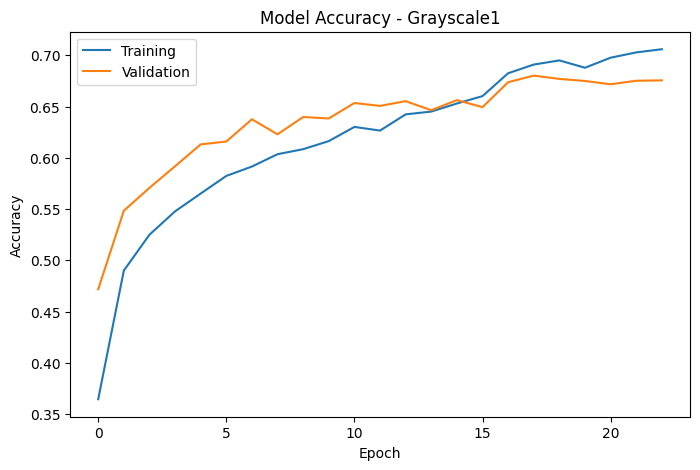

In [ ]:
# Plotting accuracies
plt.figure(figsize = (8,5))
plt.plot(history_1_grayscale.history['accuracy'])
plt.plot(history_1_grayscale.history['val_accuracy'])
plt.title('Model Accuracy - Grayscale1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### **Evaluating the Model on the Test Set**

In [ ]:
# Evaluating the model's performance on the test set
accuracy = cnn1_gray.evaluate(test_set_grayscale)

4/4 [==============================] - 0s 31ms/step - loss: 0.8116 - accuracy: 0.6172


**Observations and Insights:**<br>
First pass grayscale CNN model is a good baseline to build from. The training accuracy peak is detected at epoch 18. After 25 Epochs validation accuracy and loss begin to plateau. The initial model has room for improvement.

|  | Training | Validation | Test |
| --- | --- | --- | --- |
|  Grayscale Accuracy |0.69 | 0.68 | 0.617 |
<br>




## <span style="color:navy">Model 2: Grayscale</span>


**Note:**<br>
A second model is built with more layers and more neurons to improve upon the perfomance of the first model.<br>


In [ ]:
cnn2_gray = Sequential()

# 1) Convolutional 2D layer with 256 filters and a kernel size of 2
cnn2_gray.add(Conv2D(256, (2, 2), input_shape = (48, 48, 1), activation='relu', padding = 'same'))
# Batch normalization and leakyrelu activation
cnn2_gray.add(BatchNormalization())
cnn2_gray.add(LeakyReLU(alpha = 0.1))
# Maxpooling layer
cnn2_gray.add(MaxPooling2D(2, 2))
# 2) Convolutional 2D layer with 128 neurons and a kernel size of 2
cnn2_gray.add(Conv2D(128, (2, 2), activation='relu', padding = 'same'))
# Batch normalization and leakyrelu activation
cnn2_gray.add(BatchNormalization())
cnn2_gray.add(LeakyReLU(alpha = 0.1))
# Maxpooling layer
cnn2_gray.add(MaxPooling2D(2, 2))
# 3) Convolutional 2D layer with 64 neurons and a kernel size of 2
cnn2_gray.add(Conv2D(64, (2, 2), activation='relu', padding = 'same'))
cnn2_gray.add(BatchNormalization())
cnn2_gray.add(LeakyReLU(alpha = 0.1))
cnn2_gray.add(MaxPooling2D(2, 2))
# 4) Convolutional 2D layer with 32 neurons and a kernel size of 2
cnn2_gray.add(Conv2D(32, (2, 2), activation='relu', padding = 'same'))
cnn2_gray.add(BatchNormalization())
cnn2_gray.add(LeakyReLU(alpha = 0.1))
cnn2_gray.add(MaxPooling2D(2, 2))
# Flatten layer
cnn2_gray.add(Flatten())
# Two Dense layers with 512 and 128 neurons
cnn2_gray.add(Dense(512, activation = 'relu'))
cnn2_gray.add(Dense(128, activation = 'relu'))
# Output layer with 4 clases
cnn2_gray.add(Dense(4, activation = 'softmax'))

cnn2_gray.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 256)       1280      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 256)       1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 256)       0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 128)       131200    
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)      

### **Compiling and Training the Model**

In [ ]:
# Creating a checkpoint which saves model weights from the best epoch
checkpoint = ModelCheckpoint("./cnn2_gray.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Initiates early stopping if validation loss does not continue to improve
early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights = True)

# Initiates reduced learning rate if validation loss does not continue to improve
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_learningrate]

In [ ]:
# Compiling model with optimizer set to Adam, loss set to categorical_crossentropy, and metrics set to accuracy
cnn2_gray.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
# Fitting model with epochs set to 30
history_2_grayscale = cnn2_gray.fit(train_set_grayscale, validation_data = val_set_grayscale, epochs = 30, callbacks = callbacks_list)


Epoch 1/30
472/473 [============================>.] - ETA: 0s - loss: 1.2659 - accuracy: 0.3992
Epoch 1: val_accuracy improved from -inf to 0.42978, saving model to ./cnn2_gray.h5
473/473 [==============================] - 29s 54ms/step - loss: 1.2653 - accuracy: 0.3996 - val_loss: 1.2570 - val_accuracy: 0.4298 - lr: 0.0010
Epoch 2/30
473/473 [==============================] - ETA: 0s - loss: 1.0376 - accuracy: 0.5431
Epoch 2: val_accuracy improved from 0.42978 to 0.58389, saving model to ./cnn2_gray.h5
473/473 [==============================] - 30s 63ms/step - loss: 1.0376 - accuracy: 0.5431 - val_loss: 0.9749 - val_accuracy: 0.5839 - lr: 0.0010
Epoch 3/30
473/473 [==============================] - ETA: 0s - loss: 0.9450 - accuracy: 0.5914
Epoch 3: val_accuracy improved from 0.58389 to 0.60719, saving model to ./cnn2_gray.h5
473/473 [==============================] - 27s 58ms/step - loss: 0.9450 - accuracy: 0.5914 - val_loss: 0.9502 - val_accuracy: 0.6072 - lr: 0.0010
Epoch 4/30
472/4

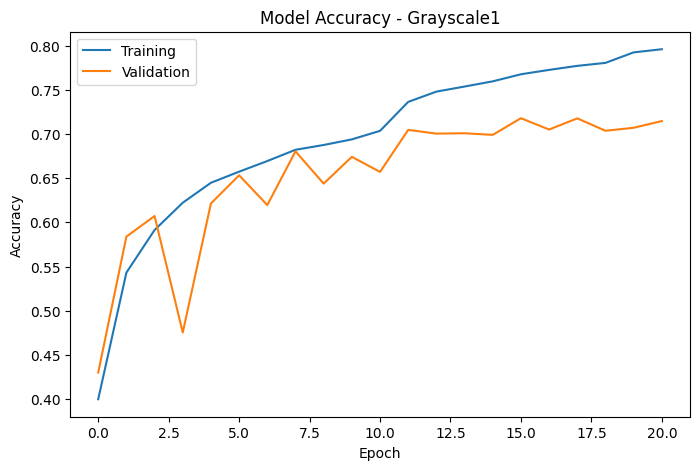

In [ ]:
# Plotting accuracies
plt.figure(figsize = (8,5))
plt.plot(history_2_grayscale.history['accuracy'])
plt.plot(history_2_grayscale.history['val_accuracy'])
plt.title('Model Accuracy - Grayscale2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### **Evaluating the Model on the Test Set**

In [ ]:
accuracy = cnn2_gray.evaluate(test_set_grayscale)

4/4 [==============================] - 0s 33ms/step - loss: 0.6805 - accuracy: 0.6797


**Observations and Insights:**<br>
As constructed, our second, deeper grayscale model performs somewhat differently than its predecessor. After 16 epochs (best epoch weights used for final epoch 21, early stopping), training accuracy stands at 0.796 and validation accuracy is 0.715, which are both higher than Model 1. The gaps between training accuracy and validation accuracy grow with each epoch towards the end so room for improvement remains. Training accuracy and loss continue to improve, while validation accuracy and loss begin to level off before early-stopping ends the training process. Accuracy on the test set is 0.68.




|  | Training | Validation | Test |
| --- | --- | --- | --- |
|  Grayscale Accuracy |0.796 | 0.715 | 0.68 |
<br>


**Observations On Grayscale Models:**<br>

* The dataset for the project, Facial_emotion_images.zip,  are black and white images with low resolution, 48 pixel squares.
* The differences between Grayscale and RGB are not significant with Grayscale being slightly better so RGB was dropped from the notebook.


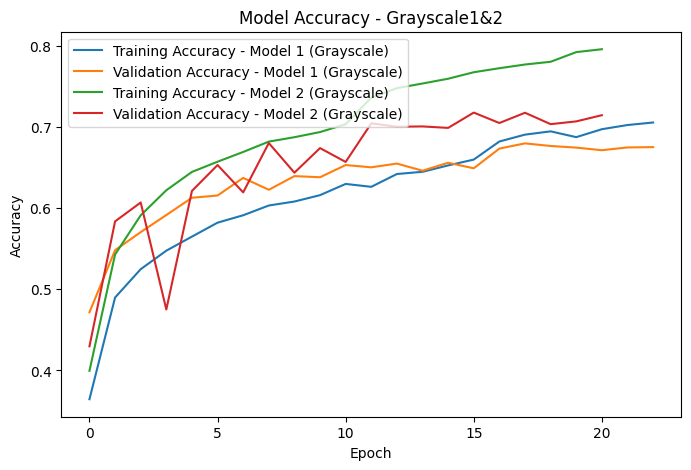

In [ ]:
# Plotting the accuracies
plt.figure(figsize = (8,5))
plt.plot(history_1_grayscale.history['accuracy'])
plt.plot(history_1_grayscale.history['val_accuracy'])
plt.plot(history_2_grayscale.history['accuracy'])
plt.plot(history_2_grayscale.history['val_accuracy'])
plt.title('Model Accuracy - Grayscale1&2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy - Model 1 (Grayscale)',
            'Validation Accuracy - Model 1 (Grayscale)',
            'Training Accuracy - Model 2 (Grayscale)',
            'Validation Accuracy - Model 2 (Grayscale)'], loc='upper left')
plt.show()

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.<br>

Data augmentation methods carried over from prior models: **horizontal_flip**, **brightness_range**, **rescale**, and **shear_range**.


In [ ]:
batch_size  = 32

datagen_train_rgb = ImageDataGenerator(horizontal_flip = True,
                                       brightness_range = (0.,2.),
                                       rescale = 1./255,
                                       shear_range = 0.3)

datagen_validation_rgb = ImageDataGenerator(horizontal_flip = True,
                                            brightness_range = (0.,2.),
                                            rescale = 1./255,
                                            shear_range = 0.3)

datagen_test_rgb = ImageDataGenerator(horizontal_flip = True,
                                      brightness_range = (0.,2.),
                                      rescale = 1./255,
                                      shear_range = 0.3)

print("\nVGG16 Data Set")
train_set_rgb = datagen_train_rgb.flow_from_directory(train_dir,
                        target_size = (img_size, img_size),
                        color_mode = "rgb",
                        batch_size = batch_size,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        seed = 42,
                        shuffle = True)

val_set_rgb = datagen_validation_rgb.flow_from_directory(validation_dir,
                        target_size = (img_size, img_size),
                        color_mode = "rgb",
                        batch_size = batch_size,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        seed = 42,
                        shuffle = False)

test_set_rgb = datagen_test_rgb.flow_from_directory(test_dir,
                        target_size = (img_size, img_size),
                        color_mode = "rgb",
                        batch_size = batch_size,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        seed = 42,
                        shuffle = False)


VGG16 Data Set
Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## <span style="color:navy">Model 3: VGG16</span>


The VGG16 model is a CNN is an enhancement to AlexNet developed at Oxford University. The VGG16 model can achieve a test accuracy of 92.7% in ImageNet, a dataset containing more than 14 million training images across 1000 object classes. It is one of the top models from the ILSVRC-2014 competition.

### **Importing the VGG16 Architecture**

In [ ]:
vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

### **Model Building**
We have imported the VGG16 model up to layer 'block4_pool', as this has shown the best performance compared to the 'block5_pool' layer. After flattening the input from 'block4_pool', 2 dense layers will be added, followed by a Dropout layer, a dense layer, and BatchNormalization.


In [ ]:
#transfer_layer = vgg.get_layer('block5_pool')
transfer_layer = vgg.get_layer('block2_pool')
vgg.trainable = False

# Flatten the input
x = Flatten()(transfer_layer.output)

# Dense layers
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)

# Classifier
pred = Dense(4, activation='softmax')(x)

# Initialize the model
vgg16_model = Model(vgg.input, pred)

### **Compiling and Training the VGG16 Model**

In [ ]:
checkpoint = ModelCheckpoint('./vgg16_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 15,     # This is increased compared to initial models, otherwise training is cut too quickly
                              verbose = 1,
                              restore_best_weights = True)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_learningrate]

In [ ]:
# Compiling model with optimizer set to Adam, loss set to categorical_crossentropy, and metrics set to accuracy
vgg16_model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# Fitting model with epochs set to 30
history_3 = vgg16_model.fit(train_set_rgb, validation_data = val_set_rgb, epochs = 30, callbacks = callbacks_list)


Epoch 1/30
473/473 [==============================] - ETA: 0s - loss: 1.2471 - accuracy: 0.4364
Epoch 1: val_accuracy improved from -inf to 0.46333, saving model to ./vgg16_model.h5
473/473 [==============================] - 38s 73ms/step - loss: 1.2471 - accuracy: 0.4364 - val_loss: 1.2416 - val_accuracy: 0.4633 - lr: 0.0010
Epoch 2/30
472/473 [============================>.] - ETA: 0s - loss: 1.0404 - accuracy: 0.5433
Epoch 2: val_accuracy improved from 0.46333 to 0.58670, saving model to ./vgg16_model.h5
473/473 [==============================] - 43s 91ms/step - loss: 1.0406 - accuracy: 0.5434 - val_loss: 0.9484 - val_accuracy: 0.5867 - lr: 0.0010
Epoch 3/30
472/473 [============================>.] - ETA: 0s - loss: 1.0491 - accuracy: 0.5331
Epoch 3: val_accuracy did not improve from 0.58670
473/473 [==============================] - 33s 70ms/step - loss: 1.0488 - accuracy: 0.5330 - val_loss: 1.1767 - val_accuracy: 0.4700 - lr: 0.0010
Epoch 4/30
472/473 [============================

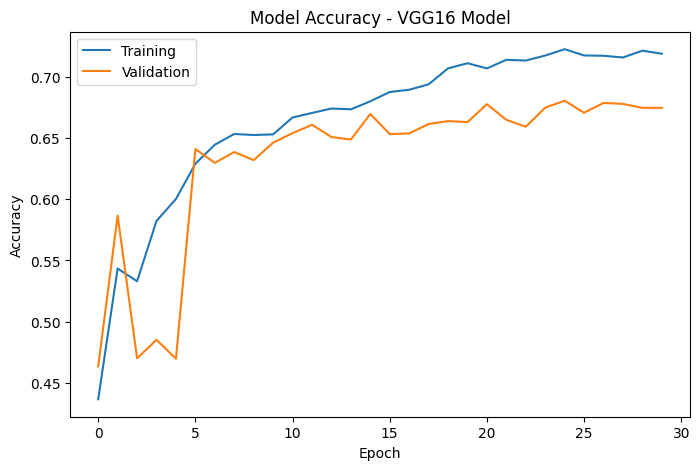

In [ ]:
# Plotting the accuracies
plt.figure(figsize = (8,5))
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy - VGG16 Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### **Evaluating the VGG16 model**

In [ ]:
# Evaluating the model's performance on the test set
accuracy = vgg16_model.evaluate(test_set_rgb)

4/4 [==============================] - 0s 47ms/step - loss: 0.7070 - accuracy: 0.7188


**Observations and Insights:**<br>
The VGG16 model performs similarly to our first 2 CNN models. The best epoch is 29, training accuracy stands at 0.72 and validation accuracy is 0.67. Accuracy and loss for both the training and validation data level off before early stopping ends the training. The model's performance on the test data stands at 0.66. These scores are roughly in line with the scores of Model 1, our baseline model.<br>
The model does not perform as well on the selected dataset as it does on ImageNet data. It is probable that due to the images being black and white and low resolution impacts performance.



|  | Train Loss | Train Accuracy | Val Loss | Val Accuracy |
| --- | --- | --- | --- | --- |
| VGG16 block2_pool |0.69 | 0.72 | 0.82 | 0.68 |
| VGG16 block5_pool |1.05 | 0.54 | 1.10 | 0.52 |

<br>


## <span style="color:navy">Model 4: ResNet v2</span>


Our second transfer learning model is ResNet v2, which is a CNN trained on over 1 million images from the ImageNet database. ResNet v2 can classify images into 1,000 different categories. Like VGG16, colormode must be set to RGB to leverage this pre-trained architecture.

In [ ]:
Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))
Resnet.summary()

171446536/171446536 [==============================] - 8s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                   

### **Model Building**
In this model, we will import till the 'conv5_block3_add' layer of the ResNet model.<br>
As with VGG16 we will add 2 dense layers followed by a DropOut layer and a dense layer and batchnormalization.

In [ ]:
#transfer_layer = Resnet.get_layer('conv5_block3_add')
transfer_layer = Resnet.get_layer('conv4_block3_add')
Resnet.trainable = False

# Flatten layer
x = Flatten()(transfer_layer.output)
# Dense layers
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
# Output layer, 4 classes
pred = Dense(4, activation='softmax')(x)
# Initialize the model
model_4 = Model(Resnet.input, pred)

### **Compiling and Training the Model**

In [ ]:
# Creating a checkpoint which saves model weights from the best epoch
checkpoint = ModelCheckpoint('./model_4.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Initiates early stopping if validation loss does not continue to improve
early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 15,    # Increased over initial models otherwise training is cut off too quickly
                              verbose = 1,
                              restore_best_weights = True)

# Initiates reduced learning rate if validation loss does not continue to improve
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_learningrate]

In [ ]:
# Compiling model with optimizer set to Adam, loss set to categorical_crossentropy, and metrics set to accuracy
model_4.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
# Fitting model with epochs set to 30
history_4 = model_4.fit(train_set_rgb, validation_data = val_set_rgb, epochs = 30, callbacks = callbacks_list)


Epoch 1/30
473/473 [==============================] - ETA: 0s - loss: 1.4715 - accuracy: 0.2604
Epoch 1: val_accuracy improved from -inf to 0.22885, saving model to ./model_4.h5
473/473 [==============================] - 42s 76ms/step - loss: 1.4715 - accuracy: 0.2604 - val_loss: 1.4524 - val_accuracy: 0.2289 - lr: 0.0010
Epoch 2/30
473/473 [==============================] - ETA: 0s - loss: 1.4062 - accuracy: 0.2526
Epoch 2: val_accuracy did not improve from 0.22885
473/473 [==============================] - 38s 79ms/step - loss: 1.4062 - accuracy: 0.2526 - val_loss: 1.4430 - val_accuracy: 0.2289 - lr: 0.0010
Epoch 3/30
472/473 [============================>.] - ETA: 0s - loss: 1.4014 - accuracy: 0.2587
Epoch 3: val_accuracy did not improve from 0.22885
473/473 [==============================] - 35s 73ms/step - loss: 1.4013 - accuracy: 0.2590 - val_loss: 1.3877 - val_accuracy: 0.2289 - lr: 0.0010
Epoch 4/30
473/473 [==============================] - ETA: 0s - loss: 1.3953 - accuracy: 0

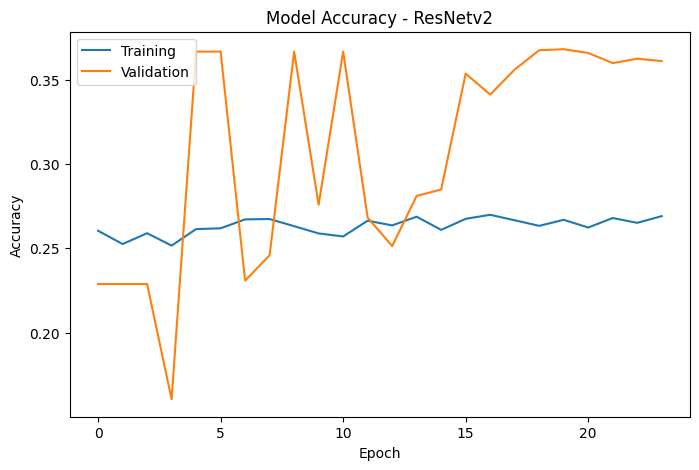

In [ ]:
# Plotting the accuracies
plt.figure(figsize = (8,5))
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model Accuracy - ResNetv2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### **Evaluating the ResNet Model**

In [ ]:
# Evaluating the model's performance on the test set
accuracy = model_4.evaluate(test_set_rgb)

4/4 [==============================] - 0s 51ms/step - loss: 1.3963 - accuracy: 0.2500


**Observations and Insights:**<br>
The ResNetv2 transfer learning model does not perform well.<br>
The ResNet v2 model was imported up to layer 'conv4_block3_add'. Other layers were selected by performance never significantly improved.
<br>

## <span style="color:navy">Model 5: EfficientNet</span>


Our third transfer learning model is EfficientNet, which is a CNN that uses 'compound scaling' to improve efficiency and, theoretically at least, performance. Like VGG16 and ResNet v2, color_mode must be set to RGB to leverage this pre-trained architecture.

In [ ]:
EfficientNet = ap.EfficientNetV2B2(include_top=False, weights="imagenet", input_shape= (48, 48, 3))
EfficientNet.summary()

35839040/35839040 [==============================] - 3s 0us/step
Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 48, 48, 3)            0         ['input_3[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 48, 48, 3)            0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2

### **Model Building**
We have imported the EfficientNet Model up to layer 'block5f_expand_activation', as this has shown the best performance compared to other layers (discussed below). The EfficientNet layers will be frozen, so the only trainable layers will be those that we add ourselves. After flattening the input from 'block5f_expand_activation', we will add the same architecture we did earlier to the VGG16 and ResNet v2 models, 2 dense layers, followed by a Dropout layer, another dense layer, and BatchNormalization.


In [ ]:
#transfer_layer_EfficientNet = EfficientNet.get_layer('block5f_expand_activation')
transfer_layer_EfficientNet = EfficientNet.get_layer('block6e_expand_activation')
EfficientNet.trainable = False

# Flatten the input
x = Flatten()(transfer_layer_EfficientNet.output)

# Dense layers
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)

# Classifier
pred = Dense(4, activation='softmax')(x)

# Initialize the model
model_5 = Model(EfficientNet.input, pred)

### **Compiling and Training the Model**

In [ ]:
checkpoint = ModelCheckpoint('./model_5.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 12,
                              verbose = 1,
                              restore_best_weights = True)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_learningrate]

In [ ]:
# Compiling model with optimizer set to Adam, loss set to categorical_crossentropy, and metrics set to accuracy
model_5.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
# Fitting model with epochs set to 30
history_5 = model_5.fit(train_set_rgb, validation_data = val_set_rgb, epochs = 30, callbacks = callbacks_list)


Epoch 1/30
473/473 [==============================] - ETA: 0s - loss: 1.4520 - accuracy: 0.2638
Epoch 1: val_accuracy improved from -inf to 0.24432, saving model to ./model_5.h5
473/473 [==============================] - 49s 84ms/step - loss: 1.4520 - accuracy: 0.2638 - val_loss: 1.3702 - val_accuracy: 0.2443 - lr: 0.0010
Epoch 2/30
472/473 [============================>.] - ETA: 0s - loss: 1.4063 - accuracy: 0.2564
Epoch 2: val_accuracy improved from 0.24432 to 0.36669, saving model to ./model_5.h5
473/473 [==============================] - 36s 75ms/step - loss: 1.4062 - accuracy: 0.2567 - val_loss: 1.3550 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 3/30
473/473 [==============================] - ETA: 0s - loss: 1.3963 - accuracy: 0.2613
Epoch 3: val_accuracy did not improve from 0.36669
473/473 [==============================] - 35s 74ms/step - loss: 1.3963 - accuracy: 0.2613 - val_loss: 1.3561 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 4/30
473/473 [==============================] - ET

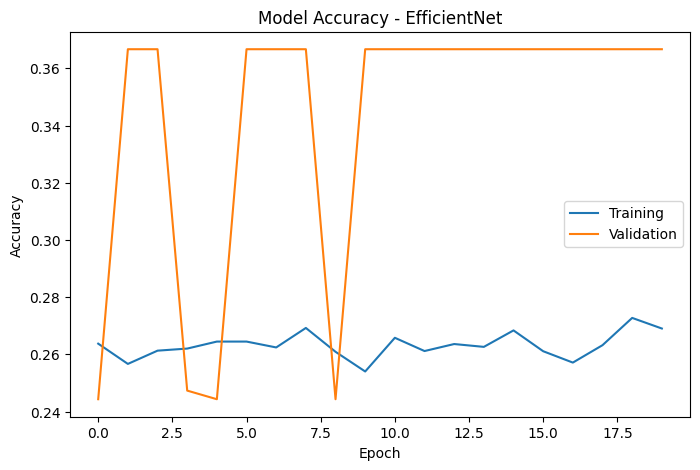

In [ ]:
# Plotting the accuracies
plt.figure(figsize = (8,5))
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('Model Accuracy - EfficientNet')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='center right')
plt.show()

### **Evaluating the EfficientNet Model**

In [ ]:
# Evaluating the model's performance on the test set
accuracy = model_5.evaluate(test_set_rgb)

4/4 [==============================] - 0s 52ms/step - loss: 1.4053 - accuracy: 0.2500


**Observations and Insights:**<br>
The ResNetv2 transfer learning model does not perform well.<br>
The ResNet v2 model was imported up to layer 'block6e_expand_activation'. Other layers were selected by performance never significantly improved.

**Transfer Learning Model Observations:**<br>
* The VGG16 model has decent performance but ResNetv2 and EfficientNet models perform badly on the selected dataset.
* The conclusion is that the transfer learning models do not perform well on low resolution black and white images.


|  | Parameters | Train Loss | Train Accuracy | Val Loss | Val Accuracy | Test Accuracy |
| --- | --- | --- | --- | --- | --- | --- |
| **Model 1**: 1st Grayscale | 605,060 | 0.68 | 0.72 | 0.78 | 0.68 | 0.65 |
| **Model 2**: 2nd Grayscale | 455,780 | 0.54 | 0.78 | 0.74 | 0.71 | 0.69 |
| **Model 3**: VGG16 | 14,714,688 | 0.71 | 0.72 | 0.80 | 0.67 | 0.66 |
| **Model 4**: ResNet V2 | 42,658,176 | 1.43 | 0.26 | 1.35 | 0.36 | 0.28 |
| **Model 5**: EfficientNet | 8,769,374 | 1.39 | 0.26 | 1.37 | 0.24 | 0.25 |

<br>

# <span style="color:navy">Milestone 1</span>
## <span style="color:navy">CNN 3: Enhance Neural Network Architecture</span>


As previewed above, it is time to expand our 2nd generation grayscale model to see if we can improve performance. Grayscale slightly outperformed RGB in our first two models, so we will leave RGB behind and proceed with color_mode set to grayscale.


## **Creating our Data Loaders**

Create new data loaders for our more complex CNN, CNN 3. Data augmentation takes place with ImageDataGenerator. Hyperparameters include **horizontal_flip**, **rescale**, **brightness_range** and **rotation_range**.

In [ ]:
batch_size  = 32

# Creating ImageDataGenerator objects for grayscale colormode
datagen_train_grayscale = ImageDataGenerator(horizontal_flip = True,
                                             rescale = 1./255,
                                             brightness_range = (0.7,1.3),
                                             rotation_range=25)

datagen_validation_grayscale = ImageDataGenerator(horizontal_flip = True,
                                                  rescale = 1./255,
                                                  brightness_range = (0.7,1.3),
                                                  rotation_range=25)

datagen_test_grayscale = ImageDataGenerator(horizontal_flip = True,
                                            rescale = 1./255,
                                            brightness_range = (0.7,1.3),
                                            rotation_range=25)


# Creating train, validation, and test sets for grayscale colormode

print("Grayscale Images")

train_set_grayscale = datagen_train_grayscale.flow_from_directory(train_dir,
                        target_size = (img_size, img_size),
                        color_mode = "grayscale",
                        batch_size = batch_size,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        seed = 42,
                        shuffle = True)

val_set_grayscale = datagen_validation_grayscale.flow_from_directory(validation_dir,
                        target_size = (img_size, img_size),
                        color_mode = "grayscale",
                        batch_size = batch_size,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        seed = 42,
                        shuffle = True)

test_set_grayscale = datagen_test_grayscale.flow_from_directory(test_dir,
                        target_size = (img_size, img_size),
                        color_mode = "grayscale",
                        batch_size = batch_size,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        seed = 42,
                        shuffle = True)


Grayscale Images
Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Model Building**

The third version of the model, CNN 3.
* The model begins with an input layer accepting an input shape of '48,48,1', given that our color_mode has been set to grayscale.
* There are 5 convolutional blocks with relu activation. Each block contains BatchNormalization, LeakyReLU, and MaxPooling layers. The first, second, and fourth blocks include a layer of GaussianNoise, while the third and fifth layers each include a Dropout layer.
* The output of the fifth convolutional block is then flattened, and fed into 2 dense layers which include additional BatchNormalization and Dropout layers.
* The architecture is completed with a softmax classifier, as this model is designed for multi-class classification. Test images will be classified as either happy, sad, neutral, or surprise.
* The model contains 2.1 million parameters, making it more complex than our 2nd generation grayscale model, but not as complex as the transfer learning models, whose complexity appeared to hurt their performance.


In [ ]:
cnn3 = Sequential()
# 1) Convolutional 2D layer with 64 filters and a kernel size of 3
cnn3.add(Conv2D(64, (3, 3), input_shape = (48, 48, 1), activation='relu', padding = 'same'))
# Add BatchNormalization, LeakyReLU activation and maxpooling
cnn3.add(BatchNormalization())
cnn3.add(LeakyReLU(alpha = 0.1))
cnn3.add(MaxPooling2D(2, 2))
#cnn3.add(GaussianNoise(0.1))
# 2) Convolutional 2D layer with 64 filters and a kernel size of 2
cnn3.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
# Add BatchNormalization, LeakyReLU activation and maxpooling
cnn3.add(BatchNormalization())
cnn3.add(LeakyReLU(alpha = 0.1))
cnn3.add(MaxPooling2D(2, 2))
#cnn3.add(GaussianNoise(0.1))
# 3) Convolutional 2D layer with 512 neurons and a kernel size of 2
cnn3.add(Conv2D(512, (2, 2), activation='relu', padding = 'same'))
# Add BatchNormalization, LeakyReLU activation and maxpooling
cnn3.add(BatchNormalization())
cnn3.add(LeakyReLU(alpha = 0.1))
cnn3.add(MaxPooling2D(2, 2))
cnn3.add(Dropout(0.1))
# 4) Convolutional 2D layer with 512 neurons and a kernel size of 2
cnn3.add(Conv2D(512, (2, 2), activation='relu', padding = 'same'))
# Add BatchNormalization, LeakyReLU activation and maxpooling
cnn3.add(BatchNormalization())
cnn3.add(LeakyReLU(alpha = 0.1))
cnn3.add(MaxPooling2D(2, 2))
#cnn3.add(GaussianNoise(0.1))
# 5) Convolutional 2D layer with 256 neurons and a kernel size of 2
cnn3.add(Conv2D(256, (2, 2), activation='relu', padding = 'same'))
cnn3.add(BatchNormalization())
cnn3.add(LeakyReLU(alpha = 0.1))
cnn3.add(MaxPooling2D(2, 2))
cnn3.add(Dropout(0.1))
# Flatten layer
cnn3.add(Flatten())
# Dense layers
cnn3.add(Dense(256, activation = 'relu'))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.1))
cnn3.add(Dense(512, activation = 'relu'))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.05))
# Output layer
cnn3.add(Dense(4, activation = 'softmax'))

cnn3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_7 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_8 (Bat  (None, 24, 24, 128)      

### **Compiling and Training the Model**

In [ ]:
# Creating a checkpoint which saves model weights from the best epoch
checkpoint = ModelCheckpoint('./cnn3.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Initiates early stopping if validation loss does not continue to improve
early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 10,
                              verbose = 1,
                              restore_best_weights = True)

# Initiates reduced learning rate if validation loss does not continue to improve
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_learningrate]

In [ ]:
# Compiling model with optimizer set to Adam, loss set to categorical_crossentropy, and metrics set to accuracy
cnn3.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
# Fitting model with epochs set to 50
history_6 = cnn3.fit(train_set_grayscale, validation_data = val_set_grayscale, epochs = 50, callbacks = callbacks_list)


Epoch 1/30
473/473 [==============================] - ETA: 0s - loss: 1.4856 - accuracy: 0.3373
Epoch 1: val_accuracy improved from -inf to 0.36267, saving model to ./cnn3.h5
473/473 [==============================] - 32s 55ms/step - loss: 1.4856 - accuracy: 0.3373 - val_loss: 1.4741 - val_accuracy: 0.3627 - lr: 0.0010
Epoch 2/30
472/473 [============================>.] - ETA: 0s - loss: 1.2225 - accuracy: 0.4411
Epoch 2: val_accuracy did not improve from 0.36267
473/473 [==============================] - 26s 54ms/step - loss: 1.2225 - accuracy: 0.4414 - val_loss: 1.5873 - val_accuracy: 0.3018 - lr: 0.0010
Epoch 3/30
473/473 [==============================] - ETA: 0s - loss: 1.0626 - accuracy: 0.5373
Epoch 3: val_accuracy improved from 0.36267 to 0.54089, saving model to ./cnn3.h5
473/473 [==============================] - 26s 54ms/step - loss: 1.0626 - accuracy: 0.5373 - val_loss: 1.0559 - val_accuracy: 0.5409 - lr: 0.0010
Epoch 4/30
472/473 [============================>.] - ETA: 0s 

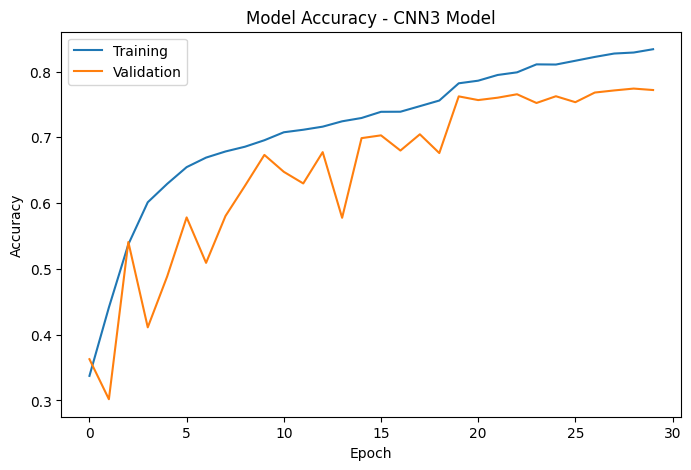

In [ ]:
# Plotting the accuracies
plt.figure(figsize = (8,5))
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title('Model Accuracy - CNN3 Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### **Evaluating the Model on Test Set**

In [ ]:
# Evaluating the model's performance on the test set
accuracy = cnn3.evaluate(test_set_grayscale)

4/4 [==============================] - 0s 34ms/step - loss: 0.5433 - accuracy: 0.8047


**Observations and Insights:**<br>
CNN 3, is the best performing model. After 30 epochs (best epoch), training accuracy stands at 0.834 and validation accuracy is 0.77. Accuracy and loss for both training and validation data improve similarly before leveling off. The test accuracy for this model is 0.805.<br>
Trial and error, and intuition from CNN methods utilized in prior models let to an improved CNN3 model.

### **Model Comparison**

Accuracy and loss scores for each model.

|  | Parameters | Train Accuracy | Train Loss | Val Accuracy | Val Loss | Test Accuracy | Test Loss |
| --- | --- | --- | --- | --- | --- | --- | --- |
| **Model 1**: Grayscale 1  | 605,060    | 0.706 | 0.725 | 0.68  | 0.79  | 0.62  | 0.81  |
| **Model 2**: Grayscale 2  | 389,604    | 0.796 | 0.496 | 0.715 | 0.74  | 0.68  | 0.68  |
| **Model 3**: VGG16 | 14,714,688 | 0.72  | 0.687 | 0.675 | 0.815 | 0.72  | 0.71  |
| **Model 4**: ResNet V2    | 42,658,176 | 0.27  | 1.38  | 0.36  | 1.37  | 0.25  | 1.40  |
| **Model 5**: EfficientNet | 8,769,374  | 0.27  | 1.38  | 0.37  | 1.35  | 0.25  | 1.41  |
| **CNN 3**: Grayscale 3    | 2,119,172  | 0.834 | 0.435 | 0.77  | 0.60  | 0.805 | 0.543 |





**Plotting the Confusion Matrix for Model CNN3**

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.61      0.62      0.62        32
           2       0.64      0.66      0.65        32
           3       0.94      0.91      0.92        32

    accuracy                           0.76       128
   macro avg       0.76      0.76      0.76       128
weighted avg       0.76      0.76      0.76       128



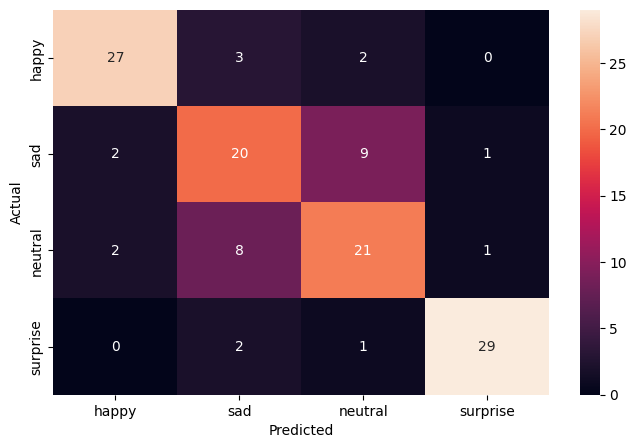

In [ ]:
test_set = datagen_test_grayscale.flow_from_directory(test_dir, target_size = (img_size, img_size),
                                              color_mode = "grayscale",
                                              batch_size = 128,
                                              seed = 42,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = False)

test_images, test_labels = next(test_set)

pred = cnn3.predict(test_images)
pred = np.argmax(pred, axis = 1)
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using the confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### **Sampling of Predicted Class Label versus Actual Class Label**

4/4 [==============================] - 0s 28ms/step


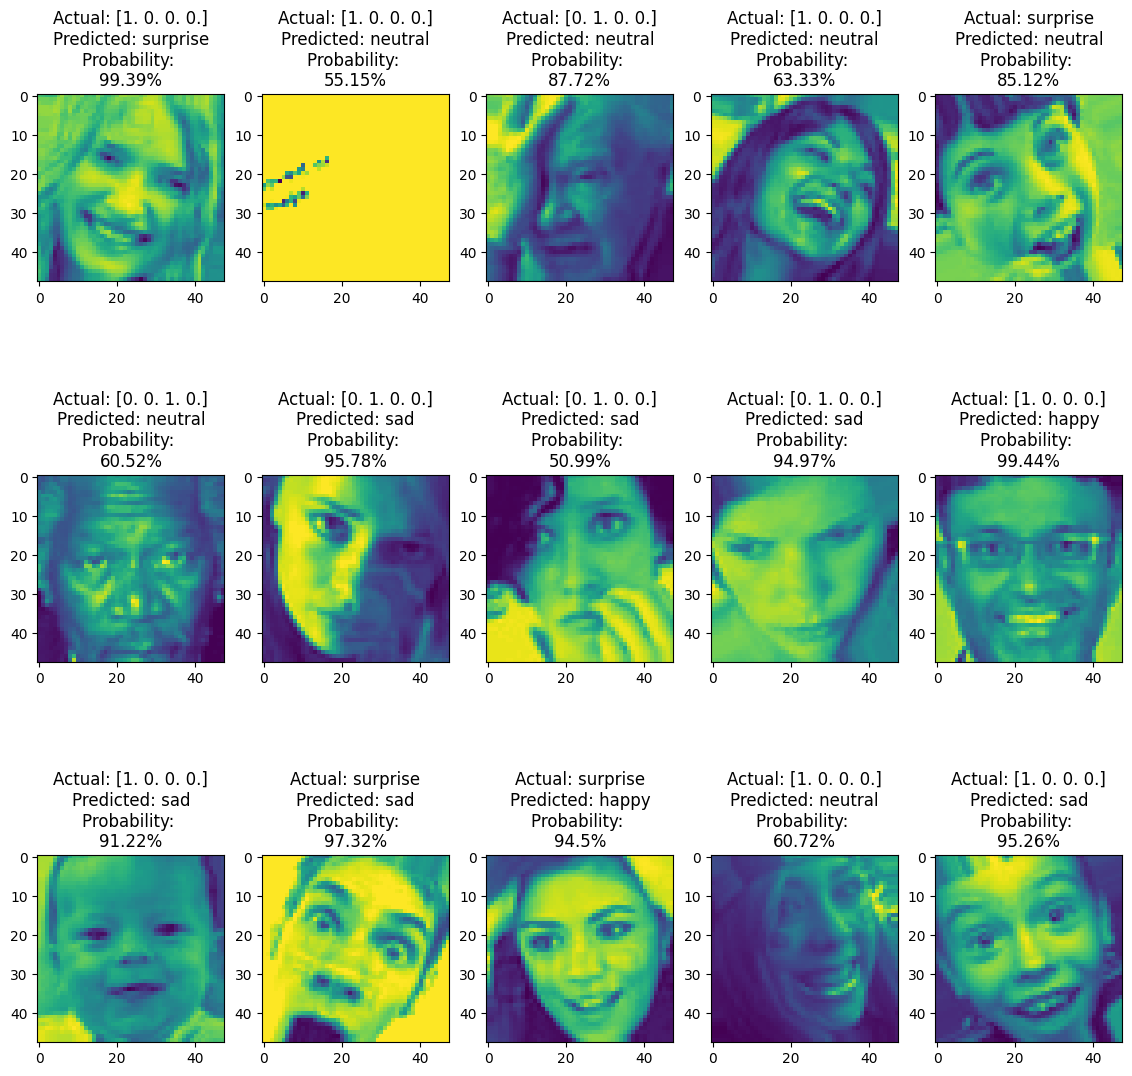

In [60]:
# Make predictions on the test set
y_pred_test = cnn3.predict(test_set_grayscale)
y_pred_test_classes = np.argmax(y_pred_test, axis = 1)
# Calculating probabilities
y_pred_test_max_probas = np.max(y_pred_test, axis = 1)
classes = ['happy', 'sad', 'neutral', 'surprise']
row = 3
col = 5

fig = plt.figure(figsize = (14, 14))

for i in range(col):
    for j in range(row):
        random_index = np.random.randint(0, len(test_labels))
        ax = fig.add_subplot(row, col, i * row + j + 1)
        ax.imshow(test_images[random_index, :])
        predict_probability = y_pred_test_max_probas[random_index]*100
        predict_label = classes[y_pred_test_classes[random_index]]
        act_label = test_labels[random_index]
        if act_label[0] == 1:
            act_label = "happy"
        elif act_label[1] == 1:
            act_label = "sad"
        elif act_label[2] == 1:
            act_label = "neutral"
        else:
            act_label = "surprise"
        ax.set_title("Actual: {}\nPredicted: {}\nProbability: \n{:.4}%".format(
               act_label, predict_label, predict_probability))
plt.gray()
plt.show()

## **Conclusion:**
6 different convolutional neural networks have been developed, including 3 "original" Convolutional Neural Networks and 3 Transfer Learning models. Observations of the performance of the 6 models have been drawn.

Potential use cases for Facial Emotion Detection include security enhancement to detect threats in a group setting and advertising and marketing applications to measure the response to marketing and advertisements.<br>
For the Capstone final notebook the CNN3 model will be used as a baseline to improve upon to create the best possible model for use by the stake holders.